In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import re
import os
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [12]:
target_paths = []
# target_paths = glob.glob('/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/long_term_forecast_wandb_BAYES_10S_TimesNet_CT2018_ftS_sl86_ll1_pl1_dm46_nh8_el4_dl1_df14_expand2_dc4_fc3_ebtimeF_dtTrue_bxlgx5kd_0')

target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/grfdm0fe_0")  #DLinear
target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/rveym5ju_0_arima")
target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/64ipw51b_0")
target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/6tsgnr7j_0")
target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/yd3cz0zj_0")# multifeature TimesNet
# target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/d5pxtrvq_0") # TimesNet_sota
# target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/ylnc6f96_0") # GRU_DIFF1_MAPE
# target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/2w3zy059_0") # GRU_DIFF1_MSE
# target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/jm0423qu_0") # GRU_DIFF1_MAPE BEST MSE
# target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/9nda5n0x_0") # DLinear mse
# target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/5wa2ow9x_0") # DLinear mape best mse
# target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/hjet7e5c_0") # DLinear mape sota
# target_paths.append("/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/3blxe2il_0") # timesnet sota
# target_paths = sorted(target_paths, key=lambda x: int(re.search(r'elay(\d+)', x).group(1)))
print(target_paths)
print(len(target_paths))

['/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/grfdm0fe_0', '/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/rveym5ju_0_arima', '/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/64ipw51b_0', '/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/6tsgnr7j_0', '/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/yd3cz0zj_0']
5


In [5]:
def relative_mean_error(y_true, y_pred):
    print(y_true.__class__)
    print(y_pred.__class__)
    
    return torch.mean(torch.abs(y_true - y_pred) / y_true)
# loss = torch.nn.MSELoss()
def MAE(pred, true):
    return np.mean(np.abs(true - pred))


def MSE(pred, true):
    return np.mean((true - pred) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((true - pred) / true))


def MSPE(pred, true):
    return np.mean(np.square((true - pred) / true))


def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)

    return mae, mse, rmse, mape, mspe
loss = metric

In [6]:
def concat_data(data,index):
    datas = []
    if data.shape[1] <= 1:
        for i in index:
            temp = data[i,:,:].squeeze(axis = 1)
            datas.append(temp)
            # datas.append(data[i,:,:].squeeze(axis = 1))
        datas = np.array(datas)
        return datas
    else:
        for i in index:
            temp = data[i,:,:].squeeze(axis = 1)
            # print(temp)
            # print("tempshape:",temp.shape)
            # temp = temp.flatten()
            # print(temp)
            datas.append(temp)
            # datas.append(temp)
        # print("datas:",datas)
        print(len(datas))
        # datas = np.array(np.concatenate(datas, axis = 0))
        datas = np.concatenate(datas, axis = 0)
        return datas

In [7]:

def visual_full_scale(  trues,  preds=None,start_index = None,plot_step = None, name='./pic/test.png', mode = 'concate', random = False , sample_num = 5,title = ''):
    """
    Results visualization
    """
    assert mode in ['concate', 'test_consistance', ]
    if plot_step is None:
        plot_step = trues.shape[0]
    if random :
        start_idx = np.random.randint(0, trues.shape[1])
    elif start_index is None:
        start_idx = 0
    else:
        start_idx = start_index
    plt.figure(figsize=(100, 6))
    true_line = []
    pred_line = []
    if mode == 'concate':
        # for index in range(start_idx, plot_step, trues.shape[1]):
        #     # print(trues[index,:,:].shape)
        #     true_line.append(trues[index,:,:].squeeze(axis = 1))
        #     # print(true_line[-1].shape)
        #     if preds is not None:
        #         pred_line.append(preds[index,:,:].squeeze(axis = 1))
        true_line = concat_data(trues, range(start_idx, plot_step, trues.shape[1]))
        if preds is not None:
            pred_line = concat_data(preds, range(start_idx, plot_step, trues.shape[1]))
    elif mode == 'test_consistance':
        random_idx = np.random.randint(0,preds.shape[0])
        for index in range(sample_num):
            plt.plot(preds[random_idx + index, sample_num-index:, :].squeeze(axis = 1), label = f'{index}th line',linewidth=2)
        plt.legend()
        plt.title(title)
        plt.savefig(name, bbox_inches='tight')
        plt.close()
        return
    true_line = np.concatenate(true_line)
    if preds is not None:
        pred_line = np.concatenate(pred_line)
    plt.plot(list(range(start_idx,start_idx+ len(true_line))),true_line, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(list(range(start_idx,start_idx + len(true_line))),pred_line, label='Prediction', linewidth=2)

    plt.legend()
    plt.savefig(name, bbox_inches='tight')
    plt.close()

In [8]:

def visual_full_scale_onestep(  trues,  preds=None,start_index = None,plot_step = None, name='./pic/test.png', mode = 'concate', random = False , sample_num = 5, manual_offset = 0, title = ''):
    """
    Results visualization
    """
    assert mode in ['concate', 'test_consistance', ]
    if plot_step is None:
        plot_step = trues.shape[0]
    if random :
        start_idx = np.random.randint(0, trues.shape[1])
    elif start_index is None:
        start_idx = 0
    else:
        start_idx = start_index
    plt.figure(figsize=(100, 6))
    true_line = []
    pred_line = []
    if mode == 'concate':
        # for index in range(start_idx, plot_step, trues.shape[1]):
        #     # print(trues[index,:,:].shape)
        #     true_line.append(trues[index,:,:].squeeze(axis = 1))
        #     # print(true_line[-1].shape)
        #     if preds is not None:
        #         pred_line.append(preds[index+manual_offset,:,:].squeeze(axis = 1))
        true_line = concat_data(trues, range(start_idx, plot_step, trues.shape[1]))
        if preds is not None:
            pred_line = concat_data(preds, range(start_idx, plot_step, trues.shape[1]))
    elif mode == 'test_consistance':
        random_idx = np.random.randint(0,preds.shape[0])
        for index in range(sample_num):
            plt.plot(preds[random_idx + index, sample_num-index:, :].squeeze(axis = 1), label = f'{index}th line',linewidth=2)
        plt.legend()
        plt.title(title)
        plt.savefig(name, bbox_inches='tight')
        plt.close()
        return
    true_line = np.concatenate(true_line)
    if preds is not None:
        pred_line = np.concatenate(pred_line)
    plt.plot(list(range(start_idx,len(true_line))),true_line, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(list(range(start_idx,len(true_line))),pred_line, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')
    plt.close()


In [9]:
##统计绘图
def plot_loss(trues,preds,labels,loss_fn,axs,title):
    loss_list = []
    # plt.figure(figsize=(20, 6))
    legend_elements = []
    errors = {'MAE': [], 'MSE': [], 'RMSE': [], 'MAPE': [], 'MSPE': []}
    colors = ['b', 'g', 'r', 'c','m']
    # fig, axs = plt.subplots(1, len(trues), figsize=(20, 6))
    for i in range(len(trues)):

        plt.figure(figsize = (10,6))
        plt.plot(trues[i][300:400], label='GroundTruth', linewidth=2)
        plt.plot(preds[i][300:400], label='Prediction', linewidth=2)
        plt.plot(preds[i][300:400] - trues[i][300:400], label='Error', linewidth=2)
        plt.title(f"{title}{labels[i]}")
        plt.legend()
        plt.grid()
        # plt.show()
        plt.savefig(f'./plot/{title}_{labels[i]}.png', bbox_inches='tight')
        # 计算损失并添加到列表中
        mae, mse,rmse,mape, mspe = loss_fn(preds[i], trues[i])
        errors['MAE'].append(mae)
        errors['MSE'].append(mse)
        errors['RMSE'].append(rmse)
        errors['MAPE'].append(mape)
        errors['MSPE'].append(mspe)
        print("errors:",errors)
        color = colors[i % len(colors)] 
        # for i, (error_name, error_values) in enumerate(errors.items()):
        #     axs.bar(i, error_values, color=colors[i], label=error_name)
        axs.bar(i, errors['MAPE'][-1], color=color)
        # axs.bar(i, errors['MSE'][-1],color=color)
        axs.grid()
        # axs.set_yscale('log')
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=f'{labels[i]}'))
        # legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=f'Sample {i+1}'))
        # axs.legend()
    axs.set_title(f"{title}") 
    # axs.legend(handles=legend_elements, loc='upper left')
    # 设置整体标题
    # fig.suptitle('Loss for Each Sample')
    # plt.show()


In [10]:
pre_number = 1


(3456, 1, 1)
(3456, 1, 1)
before concate (3456, 1, 1)
after concate (3456, 1)
range(0, 3456)
pred_line_origin shape: (3456, 1)
true_line shape: (3456, 1)
errors: {'MAE': [663566.4], 'MSE': [1067912130000.0], 'RMSE': [1033398.3], 'MAPE': [0.059647243], 'MSPE': [0.0075041573]}
errors: {'MAE': [663566.4, 711684.3], 'MSE': [1067912130000.0, 1355758000000.0], 'RMSE': [1033398.3, 1164370.2], 'MAPE': [0.059647243, 0.062599726], 'MSPE': [0.0075041573, 0.008611139]}
(3456, 1, 1)
(3456, 1, 1)
before concate (3456, 1, 1)
after concate (3456, 1)
range(0, 3456)
pred_line_origin shape: (3456, 1)
true_line shape: (3456, 1)
errors: {'MAE': [666927.2030650579], 'MSE': [1087130474690.1476], 'RMSE': [1042655.4918524851], 'MAPE': [0.059987054750580276], 'MSPE': [0.007606221938237329]}
errors: {'MAE': [666927.2030650579, 711684.3012301013], 'MSE': [1087130474690.1476, 1355757881026.1846], 'RMSE': [1042655.4918524851, 1164370.1649502122], 'MAPE': [0.059987054750580276, 0.06259972568418158], 'MSPE': [0.00760

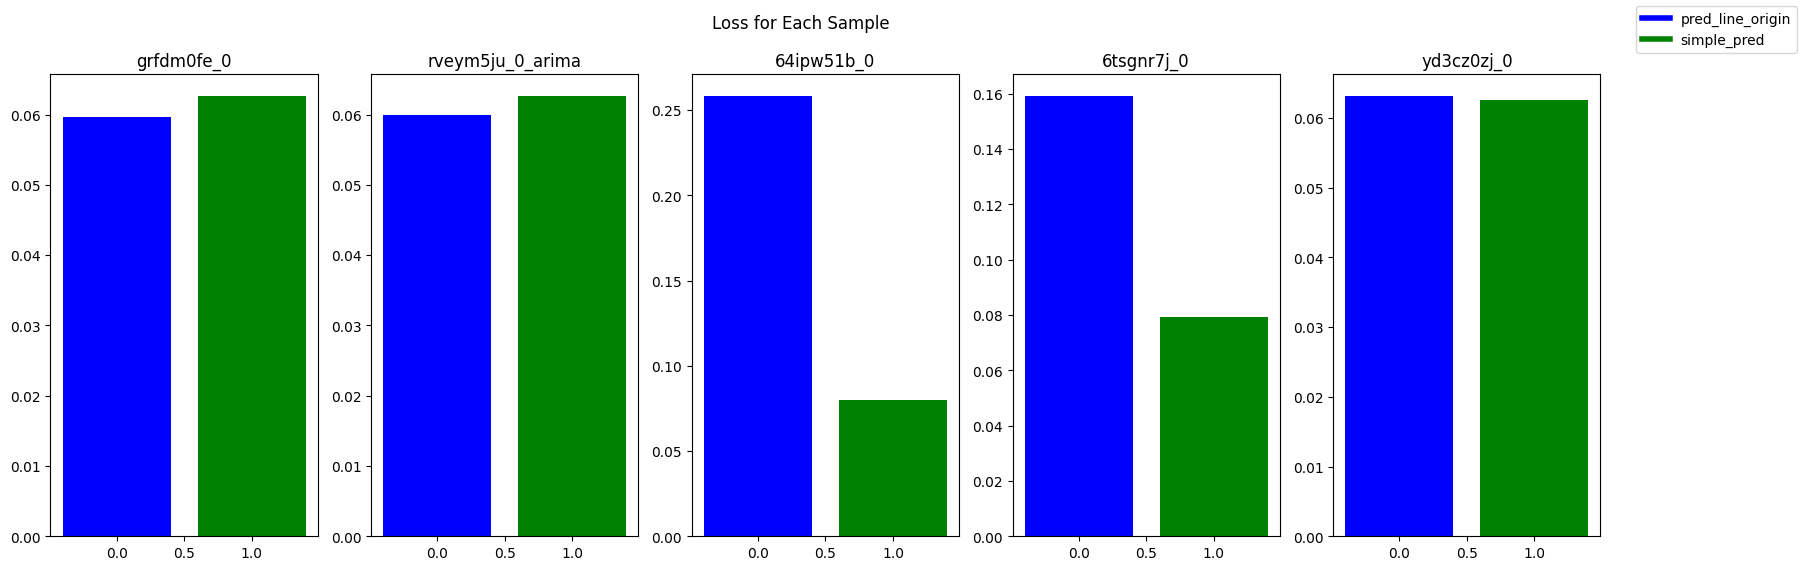

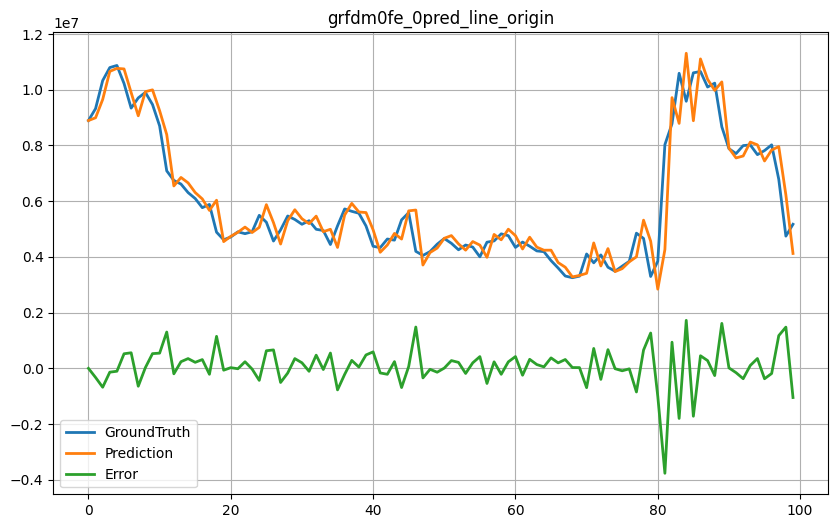

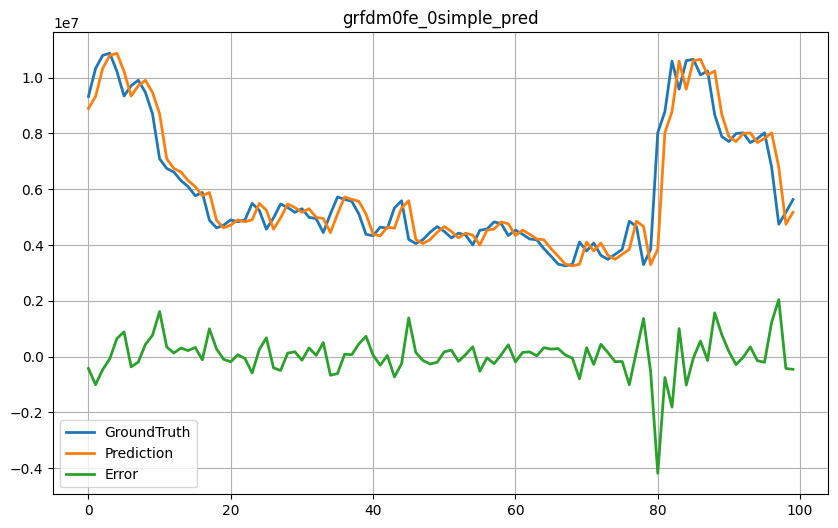

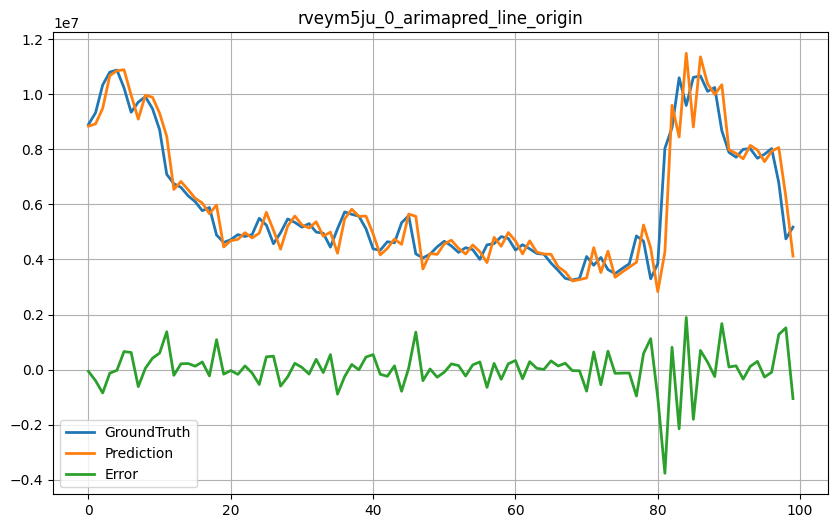

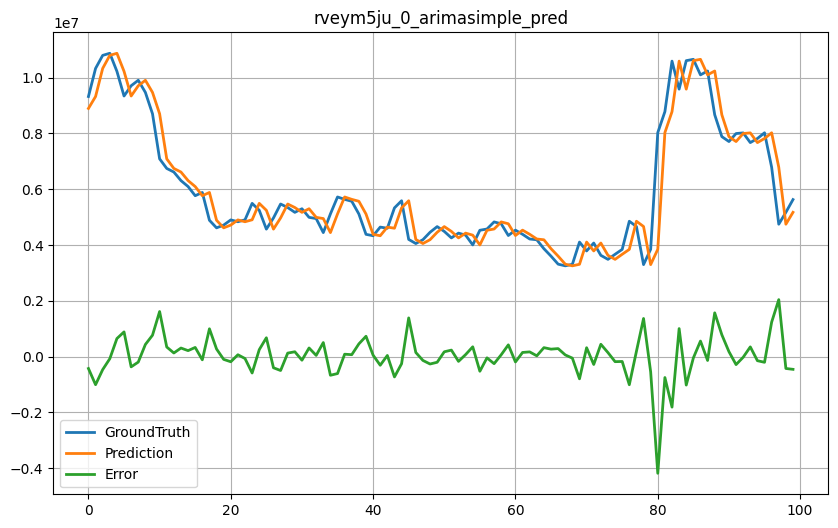

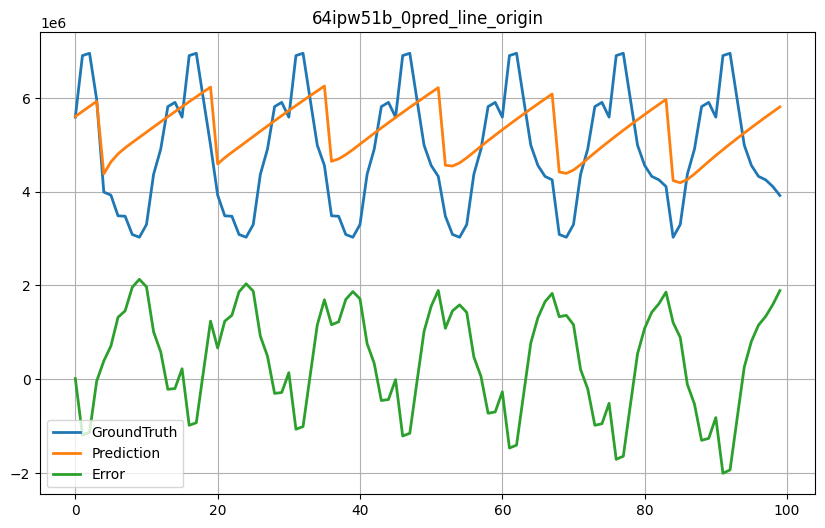

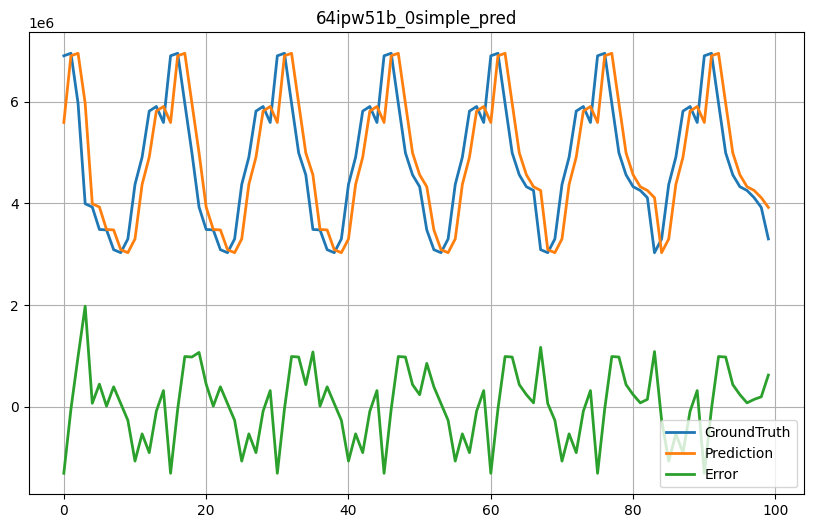

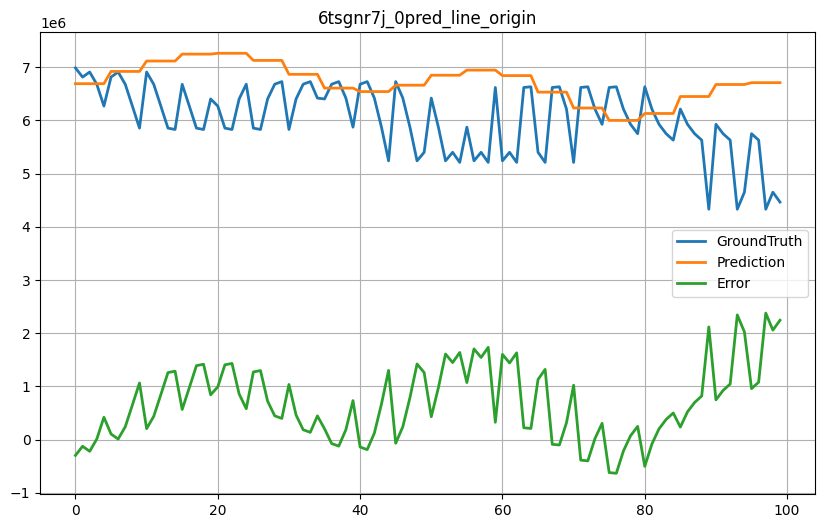

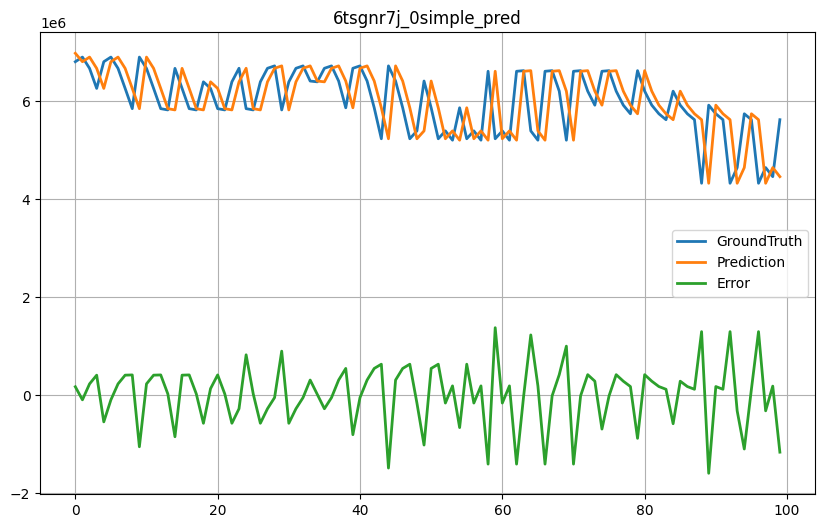

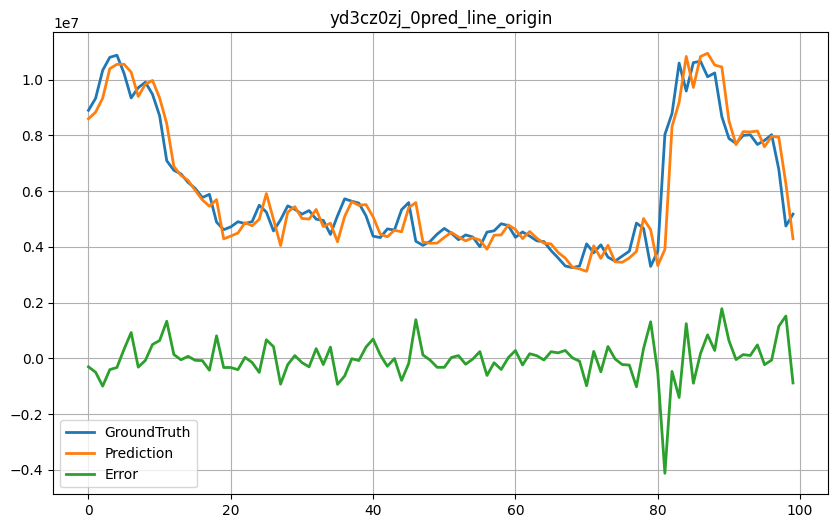

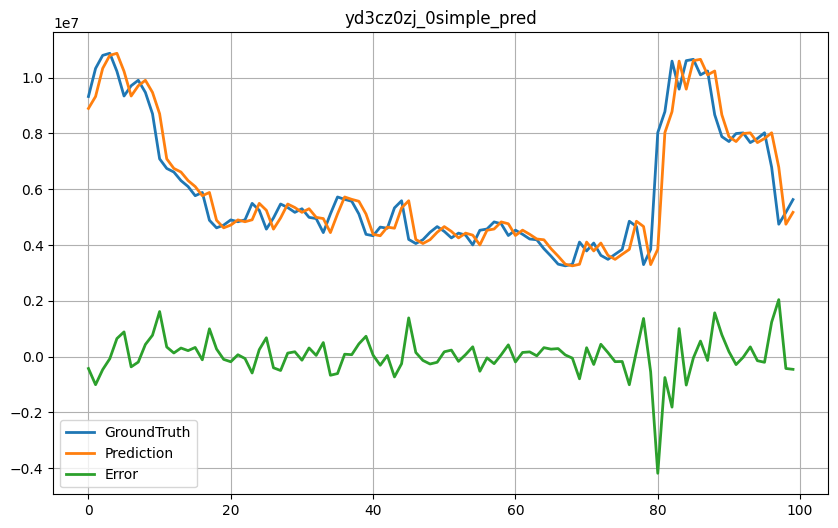

In [13]:
# 测试预测值, 预测值offset=1, 移动平均值, 朴素预测值的mse差距
fig, axs = plt.subplots(1, len(target_paths), figsize=(20, 6))
legend_elements = []
colors = ['b', 'g', 'r', 'c']
for index, path in enumerate(target_paths):
    true_line = np.load(f"{path}/true.npy")
    pred_line = np.load(f"{path}/pred.npy")
    # print(pred_line.__class__)
    print(true_line.shape)
    print(pred_line.shape)
    true_list = []
    pred_list = []
    label_list = []
    # lookback_field = extract_lookback(path)
    # lookback_field = extract_lookback(path)
    # pre_field = extract_pre(path)
    # pre_number = int(re.search(r'\d+', pre_field).group(0))
    # if lookback_field:
    #     title = f"Plot with lookback{lookback_field}, pre{pre_field}"
    #     match = re.search(r'\d+', lookback_field)
    #     if match:
    #         lookback_number = int(match.group(0))
    #         print("Extracted number:", lookback_number, pre_number)
    # else:
    #     title = "Plot"
    print("before concate",true_line.shape)
    true_line = concat_data(true_line, range(0, true_line.shape[0], pre_number))
    print("after concate",true_line.shape)
    file_name = os.path.basename(path)
    title = file_name
    # print(title)
    # print(lookback_number)
    print(range(0, pred_line.shape[0], pred_line.shape[1]))
    pred_line_origin = concat_data(pred_line, range(0, pred_line.shape[0], pre_number))#offset=0
    print("pred_line_origin shape:",pred_line_origin.shape)
    print("true_line shape:",true_line.shape)
    length = min(len(pred_line_origin), len(true_line))
    true_list.append(true_line[-length:])
    pred_list.append(pred_line_origin[-length:])
    label_list.append('pred_line_origin')
    # pred_line_offset1 = concat_data(pred_line, range(1, pred_line.shape[0], pre_number))#offset=1
    # pred_line_offset1 = pred_line_origin[1:]
    # true_line_offset1 = concat_data(true_line, range(0, true_line.shape[0]-1, true_line.shape[1]))#offset=1
    # true_line_offset1 = true_line[0:-1]
    # true_list.append(true_line_offset1)
    # pred_list.append(pred_line_offset1)
    # label_list.append('pred_line_offset1')
    # average_movement_pred = average_movement(true_line,3)#移动平均值
    # length = min(len(average_movement_pred), len(true_line))
    # true_list.append(true_line[-length+1:])
    # pred_list.append(average_movement_pred[-length:-1])
    # label_list.append('average_movement_pred')
    # simple_pred = concat_data(true_line, range(0, true_line.shape[0]-1, true_line.shape[1]))#朴素预测
    simple_pred = true_line[0:-1]
    true_list.append(true_line[1:])
    pred_list.append(simple_pred)
    label_list.append('simple_pred')
    # title = f"{lookback_field}, {pre_field}"
    # title = ""
    plot_loss(true_list,pred_list,label_list,loss,axs[index],title)
for i in range(len(label_list)):
    color = colors[i % len(colors)]
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=f'{label_list[i]}'))
fig.legend(handles=legend_elements, loc='upper right')
fig.suptitle('Loss for Each Sample')
plt.show()
    


In [2]:
test_path = "/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/ylnc6f96_0"
true_line = np.load(f"{test_path}/true.npy").squeeze()
pred_line = np.load(f"{test_path}/pred.npy").squeeze()
origin_line = pd.read_csv('/home/antigone/cluster-trace-predict/ClusterTracePredictModule/dataset/cluster_trace_2018/statisticsByCoreTimePreFrame/dataSampleFrame25s/statisiticByCoreTimePreFrame/task_type1_CTPF_8640_6912_date.csv')
start_value = origin_line.iloc[-3457]['count']
prex_value = origin_line.iloc[-3457:-1]
origin_line = origin_line.iloc[-3456:].reset_index(drop=True)
origin_true = np.load('/home/antigone/cluster-trace-predict/ClusterTracePredictModule/results/grfdm0fe_0/true.npy').squeeze()
print(true_line.shape)
print(pred_line.shape)
print(origin_line.shape)
print(origin_true.shape)
print(true_line[:10])
plt.figure(figsize=(20, 6))
for i in range(len(true_line)):
    if i == 0 :
        true_line[0] += start_value
    else:
        true_line[i] += true_line[i-1]
for i in range(len(pred_line)):
    pred_line[i] += prex_value.iloc[i]['count']
plt.plot(true_line[300:400], label='GroundTruth', linewidth=2)
plt.plot(pred_line[300:400], label='Prediction', linewidth=2)
# plt.plot(origin_true)
# plt.plot(origin_line['count'], linewidth=0.5)
print(loss(pred_line, true_line))

NameError: name 'np' is not defined

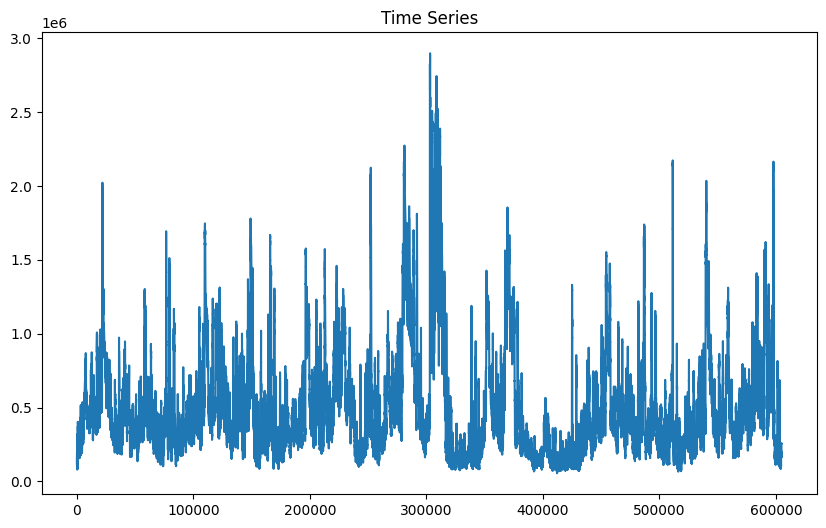

: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

# 读取数据
origin_line = pd.read_csv('/home/antigone/cluster-trace-predict/ClusterTracePredictModule/dataset/cluster_trace_2018/statisticsByCoreTimePreFrame/dataSampleFrame25s/statisiticByCoreTimePreFrame/task_type1_CTPF_8640_6912_date.csv')

# 提取需要检测的列
data = origin_line['count']

# 绘制时间序列
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title('Time Series')
plt.show()

# ADF 检验
result_adf = adfuller(data)
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])
for key, value in result_adf[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# KPSS 检验
result_kpss = kpss(data, regression='c')
print('\nKPSS Statistic:', result_kpss[0])
print('p-value:', result_kpss[1])
for key, value in result_kpss[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')